In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mf-geo-hw-april/sample_submission.csv
/kaggle/input/mf-geo-hw-april/mf_geo_train.csv
/kaggle/input/mf-geo-hw-april/mf_geo_test.csv


In [2]:
train = pd.read_csv('/kaggle/input/mf-geo-hw-april/mf_geo_train.csv')
train.head()

,point_id,lon,lat,target
0,ommNZCUV,37.590776,55.848630,-0.348157
1,nMe2LHPb,37.784210,55.750271,1.294206
2,ZgodVRqB,39.635721,47.213330,-1.039679
3,0t2jNYdz,37.704570,55.782020,-1.169339
4,U27W4QJ7,37.643983,55.730188,-0.088837


In [3]:
test = pd.read_csv('/kaggle/input/mf-geo-hw-april/mf_geo_test.csv')
test.tail()

,point_id,lon,lat,target
102,y8oQuX5v,30.353777,60.049792,0.0091
103,4nmfqUw0,92.928927,56.116262,0.0091
104,N9O45mAh,93.015993,56.023697,0.0091
105,h2InCLKa,30.381172,59.871149,0.0091
106,TQKiIgFt,30.279244,59.942110,0.0091


**Выделяем города из координат**

In [4]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="http")

def find_city(df):
    loc_list = []
    for loc in tqdm(df.values):
        try:
            loc_list.append(geolocator.reverse(str(loc[2]) + ', ' + str(loc[1])).raw['address']['city'])
        except:
            loc_list.append(geolocator.reverse(str(loc[2]) + ', ' + str(loc[1])).raw['address']['state'])
    return loc_list

In [5]:
loc_train = find_city(train)
set(loc_train)

100%|██████████| 425/425 [03:36<00:00,  1.96it/s]


{'Екатеринбург',
 'Зеленоград',
 'Казань',
 'Колпино',
 'Красноярск',
 'Москва',
 'Московская область',
 'Нижний Новгород',
 'Новосибирск',
 'Пушкин',
 'Ростов-на-Дону',
 'Самара',
 'Санкт-Петербург',
 'Уфа',
 'городской округ Новосибирск'}

In [6]:
train['city'] = loc_train
train.replace('Московская область', 'Москва', inplace=True)
train.replace('городской округ Новосибирск', 'Новосибирск', inplace=True)

In [7]:
loc_test = find_city(test)
set(loc_test)

100%|██████████| 107/107 [00:53<00:00,  1.98it/s]


{'Екатеринбург',
 'Зеленоград',
 'Казань',
 'Красноярск',
 'Москва',
 'Нижний Новгород',
 'Новосибирск',
 'Ростов-на-Дону',
 'Самара',
 'Санкт-Петербург',
 'Уфа',
 'городской округ Новосибирск'}

In [8]:
test['city'] = loc_test
test.replace('городской округ Новосибирск', 'Новосибирск', inplace=True)

Удалим города, которых нет в тестовой выборке

In [9]:
train = train.loc[~train['city'].isin(['Пушкин', 'Колпино'])]
train = train.reset_index()
train.drop("index", axis=1, inplace=True)
set(train['city'])

{'Екатеринбург',
 'Зеленоград',
 'Казань',
 'Красноярск',
 'Москва',
 'Нижний Новгород',
 'Новосибирск',
 'Ростов-на-Дону',
 'Самара',
 'Санкт-Петербург',
 'Уфа'}

**Собираем данные для городов**

In [10]:
!pip install overpass

Выделим города в BoundingBox и найдем min_lon, min_lat, max_lon, max_lat, чтобы обозначить границы города, в котором будем искать объекты

In [50]:
#Екатеринбург
min_lon = 60.2257
min_lat = 56.4156
max_lon = 60.5136
max_lat = 56.5641

ekb_bb = [min_lat,min_lon,max_lat,max_lon]

#Зеленоград
min_lon = 37.0753
min_lat = 55.5652
max_lon = 37.1605
max_lat = 56.0116

zel_bb = [min_lat,min_lon,max_lat,max_lon]

#Казань
min_lon = 48.4900
min_lat = 55.3600
max_lon = 49.2200
max_lat = 55.5600

kaz_bb = [min_lat,min_lon,max_lat,max_lon]

#Красноярск
min_lon = 92.3737
min_lat = 55.5442
max_lon = 93.1006
max_lat = 56.0801

kra_bb = [min_lat,min_lon,max_lat,max_lon]

#Москва
min_lon = 36.4800
min_lat = 55.0800
max_lon = 37.5800
max_lat = 56.0100

msc_bb = [min_lat,min_lon,max_lat,max_lon]

#Нижний Новгород
min_lon = 43.4300
min_lat = 56.1100
max_lon = 44.0600
max_lat = 56.2400

nino_bb = [min_lat,min_lon,max_lat,max_lon]

#Новосибирск
min_lon = 82.4504
min_lat = 54.4803
max_lon = 83.0936
max_lat = 55.0805

nov_bb = [min_lat,min_lon,max_lat,max_lon]

#Ростов-на-Дону
min_lon = 39.2417
min_lat = 47.0912
max_lon = 39.5105
max_lat = 47.2207

ros_bb = [min_lat,min_lon,max_lat,max_lon]

#Самара
min_lon = 49.4400
min_lat = 53.0500
max_lon = 50.2300
max_lat = 53.3300

sam_bb = [min_lat,min_lon,max_lat,max_lon]

#Санкт-Петербург
min_lon = 30.0200
min_lat = 59.4400
max_lon = 30.3400
max_lat = 60.0500

spb_bb = [min_lat,min_lon,max_lat,max_lon]

#Уфа
min_lon = 55.4600
min_lat = 54.3000
max_lon = 56.1700
max_lat = 54.5700

ufa_bb = [min_lat,min_lon,max_lat,max_lon]

In [51]:
all_boxes = [ekb_bb, zel_bb, kaz_bb, kra_bb, msc_bb, nino_bb, nov_bb, ros_bb, sam_bb, spb_bb, ufa_bb]
all_names = ['Екатеринбург', 'Зеленоград', 'Казань', 'Красноярск', 'Москва', 'Нижний Новгород', 'Новосибирск', 'Ростов-на-Дону', 'Самара', 'Санкт-Петербург', 'Уфа']

In [52]:
import overpass

types = ['bus_station', 'railway_station', 'hotel', 'hostel', 'tour_information']

def find_places(location):
    df_objects = pd.DataFrame(columns=['city', 'type', 'id', 'lon', 'lat'])
    for i in tqdm(range(len(all_boxes))):
        api = overpass.API(endpoint="https://overpass.kumi.systems/api/interpreter")
        for loc in tqdm(zip(location, types)):
            response = api.get('(node[' + loc[0] + ']({},{},{},{}););out center;'.format(*all_boxes[i]))
            if len(response) > 0:
                for j in range(len(response.features)):
                    data = {'city':all_names[i], 'type':loc[1], 'id':response.features[j]['id'], 'lon':response.features[j]['geometry']['coordinates'][0], 'lat':response.features[j]['geometry']['coordinates'][1]}
                    idx = [i for i in range(len(response.features))]
                    df = pd.DataFrame(data, index=idx)
                    df_objects = df_objects.append(data, ignore_index=True)
    df_objects.drop_duplicates(inplace=True)
    df_objects = df_objects.reset_index()
    df_objects.drop("index", axis=1, inplace=True)
    return df_objects

In [53]:
locations = ['"amenity"="bus_station"', '"railway"="station"', '"tourism"="hotel"', '"tourism"="hostel"', '"tourism"="information"']
df_objects = find_places(locations)

  0%|          | 0/11 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.13it/s]
2it [00:01,  1.15it/s]
3it [00:02,  1.16it/s]
4it [00:03,  1.17it/s]
5it [00:04,  1.17it/s]
  9%|▉         | 1/11 [00:04<00:42,  4.27s/it]
0it [00:00, ?it/s]
1it [00:00,  1.24it/s]
2it [00:01,  1.14it/s]
3it [00:02,  1.10it/s]
4it [00:03,  1.11it/s]
5it [00:04,  1.07it/s]
 18%|█▊        | 2/11 [00:08<00:40,  4.50s/it]
0it [00:00, ?it/s]
1it [00:00,  1.07it/s]
2it [00:01,  1.05it/s]
3it [00:02,  1.06it/s]
4it [00:03,  1.09it/s]
5it [00:04,  1.09it/s]
 27%|██▋       | 3/11 [00:13<00:36,  4.54s/it]
0it [00:00, ?it/s]
1it [00:00,  1.13it/s]
2it [00:02,  1.08s/it]
3it [00:06,  2.59s/it]
4it [00:07,  1.98s/it]
5it [00:09,  1.87s/it]
 36%|███▋      | 4/11 [00:22<00:45,  6.44s/it]
0it [00:00, ?it/s]
1it [00:01,  1.93s/it]
2it [00:05,  3.13s/it]
3it [00:13,  5.29s/it]
4it [00:16,  4.27s/it]
5it [00:26,  5.33s/it]
 45%|████▌     | 5/11 [00:49<01:22, 13.72s/it]
0it [00:00, ?it/s]
1it [00:00,  1.09it/s]
2it [00:01,  1

In [54]:
df_objects

,city,type,id,lon,lat
0,Екатеринбург,bus_station,3948678796,60.249625,56.494724
1,Екатеринбург,railway_station,1904638686,60.394805,56.536501
2,Екатеринбург,railway_station,4076132472,60.311803,56.439689
3,Екатеринбург,hotel,986902102,60.232860,56.497062
4,Екатеринбург,hotel,986902107,60.248034,56.494433
...,...,...,...,...,...
2147,Санкт-Петербург,tour_information,8740921650,30.237194,59.970711
2148,Уфа,bus_station,6325103485,55.886100,54.563110
2149,Уфа,railway_station,400702950,56.075743,54.523090
2150,Уфа,hotel,3930244289,55.905211,54.497377


In [55]:
from geopy import distance

def find_count_objects(df_point, df_objects, dist):
    
    df_bus = df_objects[df_objects['type'] == 'bus_station']
    df_railway = df_objects[df_objects['type'] == 'railway_station']
    df_hotel = df_objects[df_objects['type'] == 'hotel']
    df_hostel = df_objects[df_objects['type'] == 'hostel']
    df_tour_inf = df_objects[df_objects['type'] == 'tour_information']
    
    df_bus = df_bus.reset_index()
    df_bus.drop("index", axis=1, inplace=True)
    
    df_railway = df_railway.reset_index()
    df_railway.drop("index", axis=1, inplace=True)
    
    df_hotel = df_hotel.reset_index()
    df_hotel.drop("index", axis=1, inplace=True)
    
    df_hostel = df_hostel.reset_index()
    df_hostel.drop("index", axis=1, inplace=True)
    
    df_tour_inf = df_tour_inf.reset_index()
    df_tour_inf.drop("index", axis=1, inplace=True)
    
    def counter(df, df_point, dist):
        df_list = []
        for i in tqdm(range(df_point.shape[0])):
            counter = 0
            for j in range(df.shape[0]):
                if distance.geodesic((df_point['lat'][i], df_point['lon'][i]), (df['lat'][j], df['lon'][j])).km <= dist :
                    counter += 1
            df_list.append(counter)
        return df_list
    
    bus_list = counter(df_bus, df_point, dist)
    railway_list = counter(df_railway, df_point, dist)
    hotel_list = counter(df_hotel, df_point, dist)
    hostel_list = counter(df_hostel, df_point, dist)
    tour_inf_list = counter(df_tour_inf, df_point, dist)
    
    return (bus_list, railway_list, hotel_list, hostel_list, tour_inf_list)

In [56]:
bus_01, railway_01, hotel_01, hostel_01, tour_01 = find_count_objects(train, df_objects, 0.1)
bus_05, railway_05, hotel_05, hostel_05, tour_05 = find_count_objects(train, df_objects, 0.5)
bus_1, railway_1, hotel_1, hostel_1, tour_1 = find_count_objects(train, df_objects, 1.0)
bus_15, railway_15, hotel_15, hostel_15, tour_15 = find_count_objects(train, df_objects, 1.5)

100%|██████████| 420/420 [02:19<00:00,  3.00it/s]


In [57]:
train['bus_01'] = bus_01
train['bus_05'] = bus_05
train['bus_1'] = bus_1
train['bus_15'] = bus_15
train['railway_01'] = railway_01
train['railway_05'] = railway_05
train['railway_1'] = railway_1
train['railway_15'] = railway_15
train['hotel_01'] = hotel_01
train['hotel_05'] = hotel_05
train['hotel_1'] = hotel_1
train['hotel_15'] = hotel_15
train['hostel_01'] = hostel_01
train['hostel_05'] = hostel_05
train['hostel_1'] = hostel_1
train['hostel_15'] = hostel_15
train['tour_01'] = tour_01
train['tour_05'] = tour_05
train['tour_1'] = tour_1
train['tour_15'] = tour_15



In [58]:
bus_01, railway_01, hotel_01, hostel_01, tour_01 = find_count_objects(test, df_objects, 0.1)
bus_05, railway_05, hotel_05, hostel_05, tour_05 = find_count_objects(test, df_objects, 0.5)
bus_1, railway_1, hotel_1, hostel_1, tour_1 = find_count_objects(test, df_objects, 1.0)
bus_15, railway_15, hotel_15, hostel_15, tour_15 = find_count_objects(test, df_objects, 1.5)

100%|██████████| 107/107 [00:37<00:00,  2.83it/s]


In [59]:
test['bus_01'] = bus_01
test['bus_05'] = bus_05
test['bus_1'] = bus_1
test['bus_15'] = bus_15
test['railway_01'] = railway_01
test['railway_05'] = railway_05
test['railway_1'] = railway_1
test['railway_15'] = railway_15
test['hotel_01'] = hotel_01
test['hotel_05'] = hotel_05
test['hotel_1'] = hotel_1
test['hotel_15'] = hotel_15
test['hostel_01'] = hostel_01
test['hostel_05'] = hostel_05
test['hostel_1'] = hostel_1
test['hostel_15'] = hostel_15
test['tour_01'] = tour_01
test['tour_05'] = tour_05
test['tour_1'] = tour_1
test['tour_15'] = tour_15

Центры городов

In [60]:
#Екатеринбург
lat = 56.8519
lon = 60.6122
ekb_c = [lat, lon]

#Зеленоград
lat = 55.9825
lon = 37.1814
zel_c = [lat, lon]

#Казань
lat = 55.7887
lon = 49.1221
kaz_c = [lat, lon]

#Красноярск
lat = 56.0184
lon = 92.8672
kra_c = [lat, lon]

#Москва
lat = 55.7522 
lon = 37.6156
msc_c = [lat, lon]

#Нижний Новгород
lat = 56.3287
lon = 44.002
nino_c = [lat, lon]

#Новосибирск
lat = 55.0415
lon = 82.9346
nov_c = [lat, lon]

#Ростов-на-Дону
lat = 47.2313
lon = 39.7233
ros_c = [lat, lon]

#Самара
lat = 53.2001
lon = 50.15
sam_c = [lat, lon]

#Санкт-Петербург
lat = 59.9386
lon = 30.3141
spb_c = [lat, lon]

#Уфа
lat = 54.7431
lon = 55.9678
ufa_c = [lat, lon]

In [65]:
all_centres = [ekb_c, zel_c, kaz_c, kra_c, msc_c, nino_c, nov_c, ros_c, sam_c, spb_c, ufa_c]
df_centres = pd.DataFrame(columns=['city', 'lon_c', 'lat_c'])
for i in range(len(all_names)):
    data = {'city':all_names[i], 'lon_c':all_centres[i][1], 'lat_c':all_centres[i][0]}
    idx = [i for i in range(1)]
    df = pd.DataFrame(data, index=idx)
    df_centres = df_centres.append(data, ignore_index=True)

In [66]:
train = train.merge(df_centres, on=["city"])
test = test.merge(df_centres, on=['city'])

In [67]:
def dist_to_cent(df):
    distances = []
    for i in range(df.shape[0]):
        distances.append(distance.geodesic((df['lat'][i], df['lon'][i]), (df['lat_c'][i], df['lon_c'][i])).km)
    distances_log = np.log(distances)
    distances_sqrt = np.sqrt(distances)
    return distances, distances_log, distances_sqrt

In [68]:
distances, distances_log, distances_sqrt = dist_to_cent(train)
train['dist'] = distances
train['dist_log'] = distances_log
train['dist_sqrt'] = distances_sqrt

distances, distances_log, distances_sqrt = dist_to_cent(test)
test['dist'] = distances
test['dist_log'] = distances_log
test['dist_sqrt'] = distances_sqrt

**Графики**

In [69]:
!pip install folium

In [71]:
import folium

df_spb = df_objects[df_objects['city'] == 'Санкт-Петербург']
df_spb = df_spb.reset_index()
df_spb.drop("index", axis=1, inplace=True)

df_spb_bus = df_spb[df_spb['type'] == 'bus_station']
df_spb_bus = df_spb_bus.reset_index()
df_spb_bus.drop("index", axis=1, inplace=True)

df_spb_railway = df_spb[df_spb['type'] == 'railway_station']
df_spb_railway = df_spb_railway.reset_index()
df_spb_railway.drop("index", axis=1, inplace=True)

df_spb_hotel = df_spb[df_spb['type'] == 'hotel']
df_spb_hotel = df_spb_hotel.reset_index()
df_spb_hotel.drop("index", axis=1, inplace=True)

df_spb_hostel = df_spb[df_spb['type'] == 'hostel']
df_spb_hostel = df_spb_hostel.reset_index()
df_spb_hostel.drop("index", axis=1, inplace=True)

df_spb_info = df_spb[df_spb['type'] == 'tour_information']
df_spb_info = df_spb_info.reset_index()
df_spb_info.drop("index", axis=1, inplace=True)

m = folium.Map(location=[59.9386, 30.3141], zoom_start=13)
for i in range(df_spb_bus.shape[0]):
    folium.Marker(location=[df_spb_bus['lat'][i], df_spb_bus['lon'][i]], popup='bus_station', icon=folium.Icon(color="blue")).add_to(m)
for i in range(df_spb_railway.shape[0]):
    folium.Marker(location=[df_spb_railway['lat'][i], df_spb_railway['lon'][i]], popup='railway', icon=folium.Icon(color="red")).add_to(m)
for i in range(df_spb_hotel.shape[0]):
    folium.Marker(location=[df_spb_hotel['lat'][i], df_spb_hotel['lon'][i]], popup='hotel', icon=folium.Icon(color="purple")).add_to(m)
for i in range(df_spb_hostel.shape[0]):
    folium.Marker(location=[df_spb_hostel['lat'][i], df_spb_hostel['lon'][i]], popup='hostel', icon=folium.Icon(color="yellow")).add_to(m)
for i in range(df_spb_info.shape[0]):
    folium.Marker(location=[df_spb_info['lat'][i], df_spb_info['lon'][i]], popup='info', icon=folium.Icon(color="green")).add_to(m)
m

**Моделька**

In [26]:
y = train['target'].copy()
train.drop(['target'], axis=1, inplace=True)

In [27]:
train_id = train['point_id']
test_id = test['point_id']

train.drop("point_id", axis = 1, inplace = True)
test.drop("point_id", axis = 1, inplace = True)

In [28]:
test.drop('target', axis=1, inplace=True)

In [29]:
from sklearn.model_selection import train_test_split
from scipy import stats
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=1)

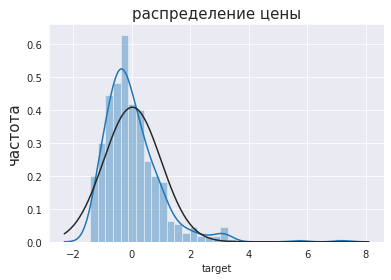

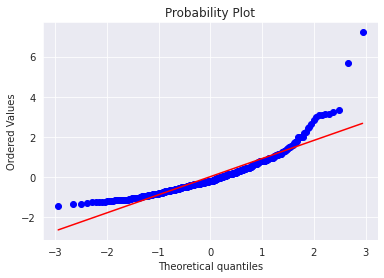

In [30]:
color = sns.color_palette()
sns.set_style('darkgrid')

sns.distplot(y, fit=stats.norm)

#price distribution
plt.ylabel('частота', fontsize=15)
plt.title('распределение цены', fontsize=15)

#probability plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

In [31]:
from catboost import CatBoostRegressor

In [32]:
cat = CatBoostRegressor(loss_function='MAE', learning_rate=0.05, cat_features=['city'], thread_count=-1)

In [33]:
cat.fit(train, y)
cat_train_pred = cat.predict(train)
cat_pred = cat.predict(test)

In [34]:
#grid = {'iterations': [1000, 1200],
#       'learning_rate': [0.05, 0.1, 0.2],
#       'depth':[6, 10]}

#grid_search_result = cat.grid_search(grid,
#                                    X=X_train,
#                                    y=y_train)
#grid_search_result

In [35]:
submission = pd.DataFrame()
submission['point_id'] = test_id
submission['target'] = cat_pred
submission.to_csv('cat.csv',index=False)